In [ ]:
#Import all needed Packages
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import math
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras


# Data Init

In [ ]:
#The Data
uploaded = 'https://raw.githubusercontent.com/kritzerenkrieg/dataset_NTT/main/NTT%202015%20-%202022.csv'

In [ ]:
# Get the data
df = pd.read_csv(uploaded, index_col='datetime', parse_dates=['datetime'])
print(df.head(6))
df['total_visitor'] = df['total_visitor'].replace(39.1, 39100)
df.head(10)

            total_visitor  total_accomodation
datetime                                     
2014-01-01        22881.0                9024
2014-02-01        19794.0                9058
2014-03-01        26642.0                9103
2014-04-01        33478.0                9187
2014-05-01        36289.0                9247
2014-06-01           39.1                9271


,total_visitor,total_accomodation
datetime,,
2014-01-01,22881.0,9024
2014-02-01,19794.0,9058
2014-03-01,26642.0,9103
2014-04-01,33478.0,9187
2014-05-01,36289.0,9247
2014-06-01,39100.0,9271
2014-07-01,41911.0,9348
2014-08-01,44722.0,9378
2014-09-01,47533.0,9400


In [ ]:
# Check the data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_visitor       108 non-null    float64
 1   total_accomodation  108 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.5 KB


In [ ]:
# Check if the data has nulls
df.isna().sum()

total_visitor         0
total_accomodation    0
dtype: int64

# GRU (80:20) Training

In [ ]:
# The Data Shape
df.shape

(108, 2)

In [ ]:
# Splitting the data
test_split=round(len(df)*0.2)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(86, 2)
(22, 2)


In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_scaled = scaler.transform(df)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[3.53981343e-01, 0.00000000e+00],
       [3.06223797e-01, 7.53379127e-03],
       [4.12166030e-01, 1.75049856e-02],
       [5.17922616e-01, 3.61178817e-02],
       [5.61410294e-01, 4.94128074e-02],
       [6.04897972e-01, 5.47307778e-02],
       [6.48385650e-01, 7.17925992e-02],
       [6.91873327e-01, 7.84400620e-02],
       [7.35361005e-01, 8.33148682e-02],
       [7.78848683e-01, 1.04365167e-01],
       [8.22336360e-01, 1.10569466e-01],
       [8.65824038e-01, 1.20097496e-01],
       [4.21649469e-01, 1.39375138e-01],
       [3.80915546e-01, 1.56436960e-01],
       [4.71743065e-01, 1.69953468e-01],
       [5.78041121e-01, 1.77930423e-01],
       [6.21219388e-01, 1.86350543e-01],
       [6.64397655e-01, 1.94549080e-01],
       [7.07575922e-01, 2.04298693e-01],
       [7.50754189e-01, 2.08065588e-01],
       [7.93932456e-01, 2.13605141e-01],
       [8.37141664e-01, 2.23576335e-01],
       [8.80288990e-01, 2.32218037e-01],
       [9.23467257e-01, 2.38200753e-01],
       [4.691594

In [ ]:
# Creating the X & Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,12)
testX,testY=createXY(df_for_testing_scaled,12)


In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (74, 12, 2)
trainY Shape--  (74,)


In [ ]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.35398134 0.        ]
 [0.3062238  0.00753379]
 [0.41216603 0.01750499]
 [0.51792262 0.03611788]
 [0.56141029 0.04941281]
 [0.60489797 0.05473078]
 [0.64838565 0.0717926 ]
 [0.69187333 0.07844006]
 [0.735361   0.08331487]
 [0.77884868 0.10436517]
 [0.82233636 0.11056947]
 [0.86582404 0.1200975 ]]
trainY[0]--  0.42164946858707586


In [ ]:
# to reset model
model = 0
model

0

In [ ]:
# Create the GRU model
model = Sequential()

# Add GRU layers
model.add(GRU(activation='relu', units=108, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=52, activation='relu', return_sequences=True))
model.add(GRU(units=4, activation='relu'))


# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Summary of the Model
model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_163 (GRU)               (None, 12, 108)           36288     
                                                                 
 dropout_44 (Dropout)        (None, 12, 108)           0         
                                                                 
 gru_164 (GRU)               (None, 12, 52)            25272     
                                                                 
 gru_165 (GRU)               (None, 4)                 696       
                                                                 
 dense_77 (Dense)            (None, 1)                 5         
                                                                 
Total params: 62261 (243.21 KB)
Trainable params: 62261 (243.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# To reset history
history = 0

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    trainX, trainY,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/100
2/2 [==============================] - 5s 557ms/step - loss: 0.3474 - val_loss: 0.0140
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.2684 - val_loss: 0.0406
Epoch 3/100
2/2 [==============================] - 0s 51ms/step - loss: 0.1977 - val_loss: 0.0820
Epoch 4/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1378 - val_loss: 0.1403
Epoch 5/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1015 - val_loss: 0.2137
Epoch 6/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0716 - val_loss: 0.2851
Epoch 7/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0702 - val_loss: 0.3301
Epoch 8/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0776 - val_loss: 0.3107
Epoch 9/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0743 - val_loss: 0.2531
Epoch 10/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0693 - val_loss: 0.1897
Epoch 11/100
2/2 [

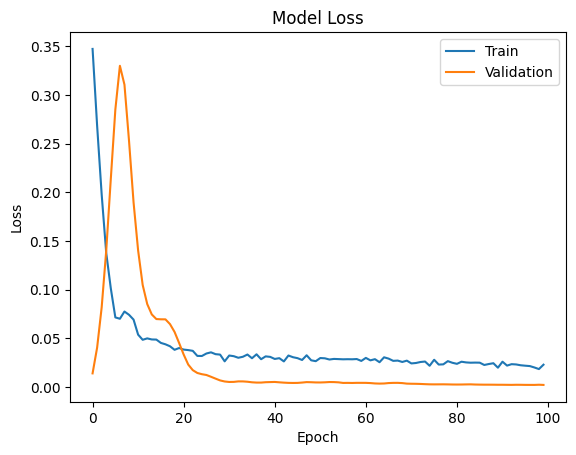

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1/1 [==============================] - 0s 420ms/step
prediction
 [[-0.00452674]
 [-0.00626791]
 [-0.00695428]
 [-0.00676761]
 [-0.00628456]
 [-0.00855067]
 [-0.00723862]
 [-0.0083813 ]
 [-0.01046353]
 [-0.01259732]]

Prediction Shape- (10, 1)


In [ ]:
# copies the prediction into 2 dimensional array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# inverse the scaling of the prediction data
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(10, 2)

In [ ]:
# inverse the scaling for of the original data
original_copies_array = np.repeat(testY,2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [-292.6042  -405.15173 -449.51752 -437.45154 -406.22763 -552.70667
 -467.89722 -541.759   -676.3521  -814.27795]

Original Values--  [ 317.  737. 1203. 1792. 1149. 3120. 2672. 2646. 2511. 4300.]


In [ ]:
# Offset the 0 in original to make it suitable for mape
original = np.where(original == 0, 1, original)

In [ ]:
original

array([ 317.,  737., 1203., 1792., 1149., 3120., 2672., 2646., 2511.,
       4300.])

In [ ]:
# Calculate RMSE, MAPE, MSE
rmse_gru1 = np.sqrt(mean_squared_error(original, pred))
mae_gru1 = mean_absolute_error(original, pred)
mape_gru1 = np.mean(np.abs((original - pred) / original) * 100)
mape_function_gru1 = mean_absolute_percentage_error(original, pred)
mse_gru1 = mean_squared_error(original, pred)

print(f"Mean Average Error (MAE): {mae_gru1}")
print(f"Root Mean Squared Error (RMSE): {rmse_gru1}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gru1}")
print(f"Mean Absolute Percentage Error Function (MAPE): {mape_function_gru1}")
print(f"Mean Squared Error (MSE): {mse_gru1}")

Mean Average Error (MAE): 2549.0945526123046
Root Mean Squared Error (RMSE): 2856.9339799081313
Mean Absolute Percentage Error (MAPE): 134.59828636583183
Mean Absolute Percentage Error Function (MAPE): 1.3459828636583182
Mean Squared Error (MSE): 8162071.765553716


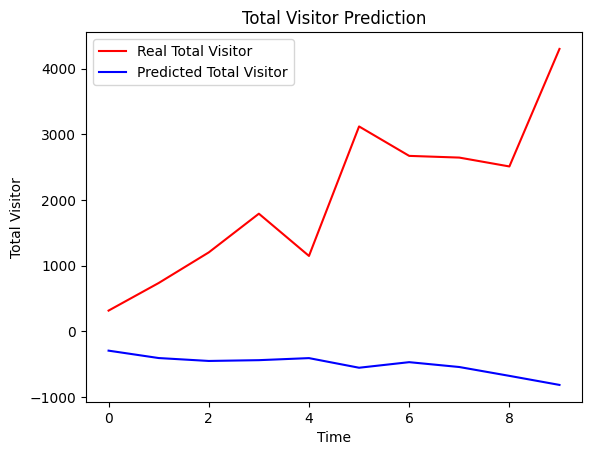

In [ ]:
# plot the prediction
plt.plot(original, color = 'red', label = 'Real Total Visitor')
plt.plot(pred, color = 'blue', label = 'Predicted Total Visitor')
plt.title('Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

In [ ]:
# # Creating the X & Y
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)
# trainX,trainY=createXY(df_for_training_scaled,12)
# testX,testY=createXY(df_for_testing_scaled,12)


# Creating the full data
def createFull(dataset,n_past):
    dataX = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
    return np.array(dataX)
allData=createFull(df_scaled,12)

In [ ]:
# Predict using all the data
prediction=model.predict(allData)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

3/3 [==============================] - 0s 8ms/step
prediction
 [[ 7.38869965e-01]
 [ 6.14320099e-01]
 [ 5.71367681e-01]
 [ 5.99780738e-01]
 [ 6.48170173e-01]
 [ 6.78199947e-01]
 [ 6.96639717e-01]
 [ 7.11278737e-01]
 [ 7.24707901e-01]
 [ 7.37682164e-01]
 [ 7.51372576e-01]
 [ 7.65224338e-01]
 [ 7.78404593e-01]
 [ 6.34443700e-01]
 [ 5.86917937e-01]
 [ 6.20301127e-01]
 [ 6.74380422e-01]
 [ 7.06356466e-01]
 [ 7.26843894e-01]
 [ 7.43635714e-01]
 [ 7.59299576e-01]
 [ 7.75239050e-01]
 [ 7.90852726e-01]
 [ 8.05083990e-01]
 [ 8.18273604e-01]
 [ 6.49520218e-01]
 [ 5.94508350e-01]
 [ 6.72719359e-01]
 [ 6.88842058e-01]
 [ 7.22555816e-01]
 [ 6.86142921e-01]
 [ 7.04290211e-01]
 [ 7.57843912e-01]
 [ 7.29801238e-01]
 [ 7.10078597e-01]
 [ 6.79141760e-01]
 [ 6.47096395e-01]
 [ 4.68989193e-01]
 [ 4.34123933e-01]
 [ 4.70596015e-01]
 [ 5.00106454e-01]
 [ 5.08119166e-01]
 [ 4.59609509e-01]
 [ 4.85135883e-01]
 [ 5.06891191e-01]
 [ 6.03404701e-01]
 [ 5.06688476e-01]
 [ 4.50468242e-01]
 [ 4.52416360e-01]
 [ 2.9

In [ ]:
# Reshape the prediction array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# Inverse the prediction array
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(96, 2)

In [ ]:
# Inverse the original data
original_copies_array = np.repeat(df_scaled[:,1],2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(df_scaled),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 4.7759816e+04  3.9709035e+04  3.6932637e+04  3.8769227e+04
  4.1897070e+04  4.3838168e+04  4.5030094e+04  4.5976348e+04
  4.6844395e+04  4.7683039e+04  4.8567973e+04  4.9463336e+04
  5.0315293e+04  4.1009805e+04  3.7937789e+04  4.0095645e+04
  4.3591277e+04  4.5658176e+04  4.6982461e+04  4.8067867e+04
  4.9080367e+04  5.0110676e+04  5.1119930e+04  5.2039824e+04
  5.2892387e+04  4.1984336e+04  3.8428426e+04  4.3483906e+04
  4.4526062e+04  4.6705285e+04  4.4351594e+04  4.5524613e+04
  4.8986273e+04  4.7173621e+04  4.5898770e+04  4.3899043e+04
  4.1827664e+04  3.0314992e+04  2.8061338e+04  3.0418855e+04
  3.2326381e+04  3.2844316e+04  2.9708699e+04  3.1358699e+04
  3.2764939e+04  3.9003477e+04  3.2751836e+04  2.9117816e+04
  2.9243740e+04  1.9258604e+04  1.3627899e+04  1.1499268e+04
  1.1190394e+04  1.0189862e+04  9.4884561e+03  8.6564639e+03
  7.8617021e+03  6.5731113e+03  6.0536440e+03  5.7934116e+03
  6.0425093e+03  6.1760566e+03  5.2435688e+03  4.0769883e+03
  2.86203

In [ ]:
# Prediction for all the data
num_predictions = len(pred)

# Create a date range starting from January 1st, 2014
date_index = pd.date_range(start='2014-01-01	', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(pred, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test

,total_visitor
2014-01-01,47759.816406
2014-02-01,39709.035156
2014-03-01,36932.636719
2014-04-01,38769.226562
2014-05-01,41897.070312
...,...
2021-08-01,-552.706665
2021-09-01,-467.897217
2021-10-01,-541.758972
2021-11-01,-676.352112


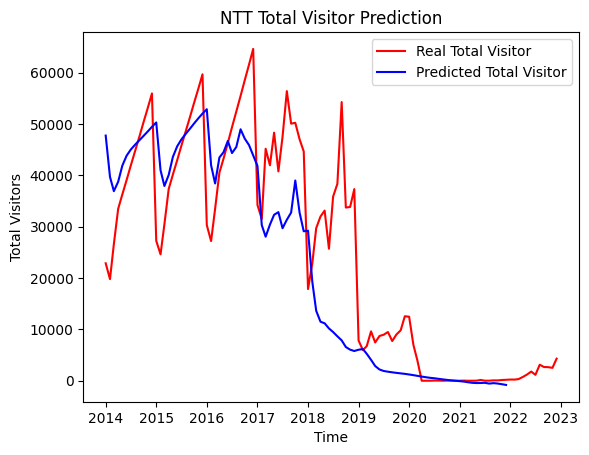

In [ ]:
plt.plot(df['total_visitor'], color = 'red', label = 'Real Total Visitor')
plt.plot(df_test, color = 'blue', label = 'Predicted Total Visitor')
plt.title('NTT Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitors')
plt.legend()
plt.show()

# GRU (80:20) Prediction

In [ ]:
df_12_months_past=df.iloc[-12:,:]
df_12_months_past.tail()

,total_visitor,total_accomodation
datetime,,
2022-08-01,3120.0,14541
2022-09-01,2672.0,14575
2022-10-01,2646.0,14586
2022-11-01,2511.0,14659
2022-12-01,4300.0,14782


In [ ]:
df_12_months_future = pd.read_csv(uploaded, index_col=[0], parse_dates=['datetime'])
df_12_months_future = df_12_months_future[:12]
df_12_months_future = df_12_months_future.drop('total_visitor', axis=1)
df_12_months_future

,total_accomodation
datetime,
2014-01-01,9024
2014-02-01,9058
2014-03-01,9103
2014-04-01,9187
2014-05-01,9247
2014-06-01,9271
2014-07-01,9348
2014-08-01,9378
2014-09-01,9400


In [ ]:
df_12_months_future["total_visitor"]=0
df_12_months_future=df_12_months_future[["total_visitor","total_accomodation"]]
old_scaled_array=scaler.transform(df_12_months_past)
new_scaled_array=scaler.transform(df_12_months_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [ ]:
full_df.shape

(24, 2)

In [ ]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=12
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 25ms/step


In [ ]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,2, axis=-1)
y_pred_future_12_months = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),2)))[:,0]
print(y_pred_future_12_months)

[ -687.92206   535.20703  3710.7695   8775.054   14651.403   20508.453
 25541.357   29578.463   32697.924   35087.6     36995.395   38536.67   ]


In [ ]:
len(y_pred_future_12_months)

12

In [ ]:
# Assuming your predictions are for 12 months
num_predictions = len(y_pred_future_12_months)

# Create a date range starting from January 1st, 2023
date_index = pd.date_range(start='2023-01-01', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test1 = pd.DataFrame(y_pred_future_12_months, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test1

,total_visitor
2023-01-01,-687.922058
2023-02-01,535.207031
2023-03-01,3710.769531
2023-04-01,8775.053711
2023-05-01,14651.403320
2023-06-01,20508.453125
2023-07-01,25541.357422
2023-08-01,29578.462891
2023-09-01,32697.923828
2023-10-01,35087.601562


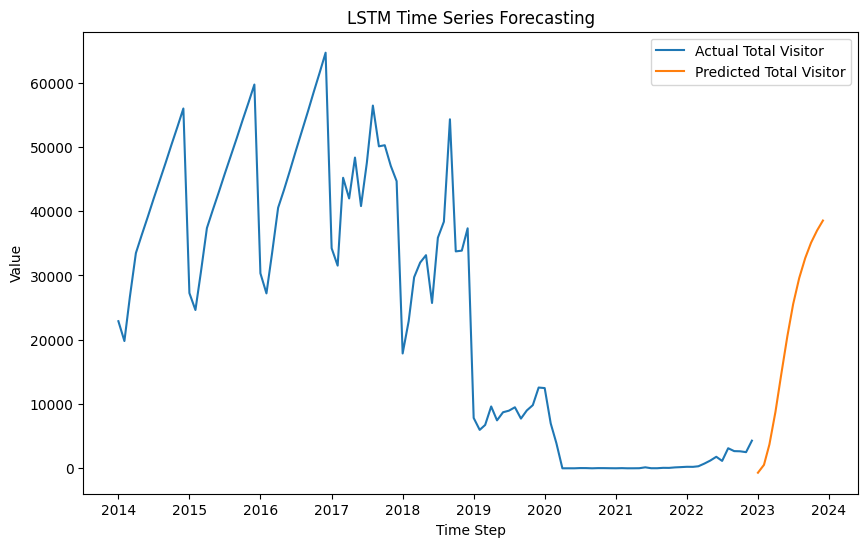

In [ ]:
# Plot the results for both targets (humidity and temperature)
plt.figure(figsize=(10, 6))

plt.plot(df['total_visitor'], label='Actual Total Visitor')
plt.plot(df_test1['total_visitor'], label='Predicted Total Visitor')

plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

# GRU (70:30) Training

In [ ]:
# The Data Shape
df.shape

(108, 2)

In [ ]:
# Splitting the data
test_split=round(len(df)*0.3)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(76, 2)
(32, 2)


In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_scaled = scaler.transform(df)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.35398134, 0.        ],
       [0.3062238 , 0.00871125],
       [0.41216603, 0.02024084],
       [0.51792262, 0.04176275],
       [0.56141029, 0.05713554],
       [0.60489797, 0.06328465],
       [0.64838565, 0.08301307],
       [0.69187333, 0.09069946],
       [0.735361  , 0.09633615],
       [0.77884868, 0.1206764 ],
       [0.82233636, 0.12785037],
       [0.86582404, 0.13886754],
       [0.42164947, 0.16115808],
       [0.38091555, 0.1808865 ],
       [0.47174307, 0.1965155 ],
       [0.57804112, 0.20573917],
       [0.62121939, 0.21547528],
       [0.66439765, 0.22495516],
       [0.70757592, 0.23622854],
       [0.75075419, 0.24058417],
       [0.79393246, 0.2469895 ],
       [0.83714166, 0.25851909],
       [0.88028899, 0.2685114 ],
       [0.92346726, 0.27542916],
       [0.46915949, 0.2782475 ],
       [0.42087594, 0.29310787],
       [0.51792262, 0.3151422 ],
       [0.62703631, 0.31847297],
       [0.66959575, 0.34383807],
       [0.71679636, 0.36894696],
       [0.

In [ ]:
# Creating the X & Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,12)
testX,testY=createXY(df_for_testing_scaled,12)


In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (64, 12, 2)
trainY Shape--  (64,)


In [ ]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.35398134 0.        ]
 [0.3062238  0.00871125]
 [0.41216603 0.02024084]
 [0.51792262 0.04176275]
 [0.56141029 0.05713554]
 [0.60489797 0.06328465]
 [0.64838565 0.08301307]
 [0.69187333 0.09069946]
 [0.735361   0.09633615]
 [0.77884868 0.1206764 ]
 [0.82233636 0.12785037]
 [0.86582404 0.13886754]]
trainY[0]--  0.42164946858707586


In [ ]:
# to reset model
model = 0
model

0

In [ ]:
# Create the GRU model
model = Sequential()

# Add GRU layers
model.add(GRU(activation='relu', units=108, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=52, activation='relu', return_sequences=True))
model.add(GRU(units=4, activation='relu'))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Summary of the Model
model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_166 (GRU)               (None, 12, 108)           36288     
                                                                 
 dropout_45 (Dropout)        (None, 12, 108)           0         
                                                                 
 gru_167 (GRU)               (None, 12, 52)            25272     
                                                                 
 gru_168 (GRU)               (None, 4)                 696       
                                                                 
 dense_78 (Dense)            (None, 1)                 5         
                                                                 
Total params: 62261 (243.21 KB)
Trainable params: 62261 (243.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# To reset history
history = 0

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    trainX, trainY,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/100
2/2 [==============================] - 5s 818ms/step - loss: 0.4681 - val_loss: 0.0161
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 0.4045 - val_loss: 0.0100
Epoch 3/100
2/2 [==============================] - 0s 97ms/step - loss: 0.3690 - val_loss: 0.0046
Epoch 4/100
2/2 [==============================] - 0s 87ms/step - loss: 0.3264 - val_loss: 0.0026
Epoch 5/100
2/2 [==============================] - 0s 93ms/step - loss: 0.2803 - val_loss: 0.0047
Epoch 6/100
2/2 [==============================] - 0s 75ms/step - loss: 0.2402 - val_loss: 0.0125
Epoch 7/100
2/2 [==============================] - 0s 72ms/step - loss: 0.1930 - val_loss: 0.0298
Epoch 8/100
2/2 [==============================] - 0s 74ms/step - loss: 0.1478 - val_loss: 0.0616
Epoch 9/100
2/2 [==============================] - 0s 76ms/step - loss: 0.1060 - val_loss: 0.1177
Epoch 10/100
2/2 [==============================] - 0s 75ms/step - loss: 0.0696 - val_loss: 0.2076
Epoch 11/100
2/2 [

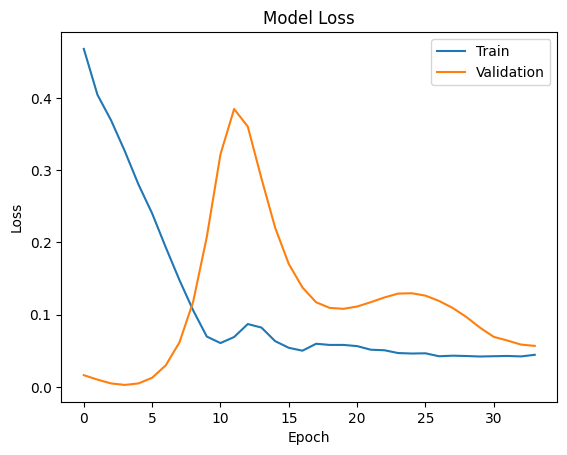

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1/1 [==============================] - 0s 435ms/step
prediction
 [[0.14012347]
 [0.14123581]
 [0.14235538]
 [0.143441  ]
 [0.14451209]
 [0.14556359]
 [0.14654836]
 [0.147477  ]
 [0.14847517]
 [0.14958173]
 [0.15073241]
 [0.15183051]
 [0.15283692]
 [0.15385914]
 [0.15498748]
 [0.15623438]
 [0.15761828]
 [0.15901811]
 [0.16030148]
 [0.16150372]]

Prediction Shape- (20, 1)


In [ ]:
# copies the prediction into 2 dimensional array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# inverse the scaling of the prediction data
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(20, 2)

In [ ]:
# inverse the scaling for of the original data
original_copies_array = np.repeat(testY,2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 9057.441  9129.342  9201.71   9271.883  9341.117  9409.085  9472.739
  9532.766  9597.286  9668.813  9743.192  9814.172  9879.226  9945.301
 10018.236 10098.834 10188.288 10278.771 10361.728 10439.438]

Original Values--  [  13.  152.   12.   12.   73.   64.  142.  184.  234.  226.  317.  737.
 1203. 1792. 1149. 3120. 2672. 2646. 2511. 4300.]


In [ ]:
# Offset the 0 in original to make it suitable for mape
original = np.where(original == 0, 1, original)

In [ ]:
original

array([  13.,  152.,   12.,   12.,   73.,   64.,  142.,  184.,  234.,
        226.,  317.,  737., 1203., 1792., 1149., 3120., 2672., 2646.,
       2511., 4300.])

In [ ]:
# Calculate RMSE, MAPE, MSE
rmse_gru2 = np.sqrt(mean_squared_error(original, pred))
mae_gru2 = mean_absolute_error(original, pred)
mape_gru2 = np.mean(np.abs((original - pred) / original) * 100)
mape_function_gru2 = mean_absolute_percentage_error(original, pred)
mse_gru2 = mean_squared_error(original, pred)

print(f"Mean Average Error (MAE): {mae_gru2}")
print(f"Root Mean Squared Error (RMSE): {rmse_gru2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gru2}")
print(f"Mean Absolute Percentage Error Function (MAPE): {mape_function_gru2}")
print(f"Mean Squared Error (MSE): {mse_gru2}")

Mean Average Error (MAE): 8644.51845703125
Root Mean Squared Error (RMSE): 8693.585592936262
Mean Absolute Percentage Error (MAPE): 14187.837100646026
Mean Absolute Percentage Error Function (MAPE): 141.8783710064602
Mean Squared Error (MSE): 75578430.46170893


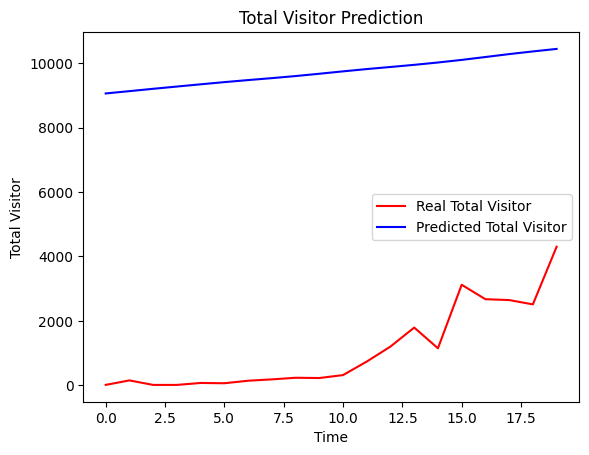

In [ ]:
# plot the prediction
plt.plot(original, color = 'red', label = 'Real Total Visitor')
plt.plot(pred, color = 'blue', label = 'Predicted Total Visitor')
plt.title('Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

In [ ]:
# # Creating the X & Y
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)
# trainX,trainY=createXY(df_for_training_scaled,12)
# testX,testY=createXY(df_for_testing_scaled,12)


# Creating the full data
def createFull(dataset,n_past):
    dataX = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
    return np.array(dataX)
allData=createFull(df_scaled,12)

In [ ]:
# Predict using all the data
prediction=model.predict(allData)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

3/3 [==============================] - 0s 9ms/step
prediction
 [[0.10062182]
 [0.1020506 ]
 [0.10109341]
 [0.09911077]
 [0.09759723]
 [0.09714236]
 [0.09779682]
 [0.09938883]
 [0.10164618]
 [0.10434705]
 [0.1073664 ]
 [0.1106244 ]
 [0.11401097]
 [0.11516148]
 [0.11397907]
 [0.11179754]
 [0.10995163]
 [0.10927041]
 [0.10995995]
 [0.11185771]
 [0.11455395]
 [0.11787292]
 [0.12157821]
 [0.12545204]
 [0.12937415]
 [0.13136029]
 [0.13087267]
 [0.1296071 ]
 [0.12839578]
 [0.12797831]
 [0.127948  ]
 [0.1284854 ]
 [0.13004918]
 [0.13215606]
 [0.13436238]
 [0.13612664]
 [0.13728659]
 [0.1361876 ]
 [0.13355789]
 [0.1309517 ]
 [0.12927617]
 [0.12848586]
 [0.12795493]
 [0.12805007]
 [0.1290121 ]
 [0.1317725 ]
 [0.13440329]
 [0.13625379]
 [0.13754387]
 [0.13641438]
 [0.13315904]
 [0.12958336]
 [0.12671724]
 [0.12476803]
 [0.1237082 ]
 [0.12331934]
 [0.12349585]
 [0.12384843]
 [0.12465619]
 [0.12565885]
 [0.12695645]
 [0.12863117]
 [0.1300148 ]
 [0.13091403]
 [0.13135052]
 [0.13154896]
 [0.13173535]

In [ ]:
# Reshape the prediction array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# Inverse the prediction array
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(96, 2)

In [ ]:
# Inverse the original data
original_copies_array = np.repeat(df_scaled[:,1],2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(df_scaled),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 6504.0938  6596.4487  6534.577   6406.421   6308.587   6279.185
  6321.489   6424.3945  6570.3076  6744.889   6940.0566  7150.651
  7369.5547  7443.923   7367.493   7226.4814  7107.1636  7063.13
  7107.7007  7230.3706  7404.653   7619.188   7858.694   8109.0947
  8362.615   8490.998   8459.479   8377.673   8299.375   8272.39
  8270.431   8305.168   8406.249   8542.436   8685.05    8799.09
  8874.067   8803.03    8633.048   8464.587   8356.282   8305.197
  8270.879   8277.028   8339.213   8517.643   8687.694   8807.309
  8890.698   8817.689   8607.268   8376.139   8190.8755  8064.881
  7996.374   7971.2383  7982.6484  8005.4385  8057.652   8122.463
  8206.338   8314.591   8404.027   8462.152   8490.366   8503.193
  8515.241   8538.87    8571.602   8610.41    8652.421   8702.363
  8760.342   8827.296   8902.468   8980.432   9057.441   9129.342
  9201.71    9271.883   9341.117   9409.085   9472.739   9532.766
  9597.286   9668.813   9743.192   9814.172   9879.226   9945.3

In [ ]:
# Prediction for all the data
num_predictions = len(pred)

# Create a date range starting from January 1st, 2014
date_index = pd.date_range(start='2014-01-01	', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(pred, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test

,total_visitor
2014-01-01,6504.093750
2014-02-01,6596.448730
2014-03-01,6534.577148
2014-04-01,6406.420898
2014-05-01,6308.586914
...,...
2021-08-01,10098.833984
2021-09-01,10188.288086
2021-10-01,10278.771484
2021-11-01,10361.727539


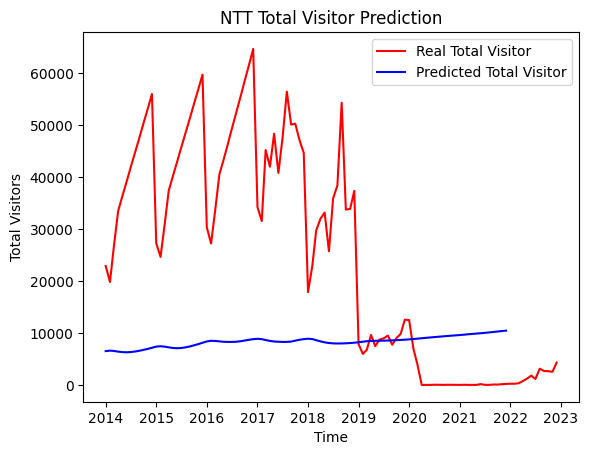

In [ ]:
plt.plot(df['total_visitor'], color = 'red', label = 'Real Total Visitor')
plt.plot(df_test, color = 'blue', label = 'Predicted Total Visitor')
plt.title('NTT Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitors')
plt.legend()
plt.show()

# GRU (70:30) Prediction

In [ ]:
df_12_months_past=df.iloc[-12:,:]
df_12_months_past.tail()

,total_visitor,total_accomodation
datetime,,
2022-08-01,3120.0,14541
2022-09-01,2672.0,14575
2022-10-01,2646.0,14586
2022-11-01,2511.0,14659
2022-12-01,4300.0,14782


In [ ]:
df_12_months_future = pd.read_csv(uploaded, index_col=[0], parse_dates=['datetime'])
df_12_months_future = df_12_months_future[:12]
df_12_months_future = df_12_months_future.drop('total_visitor', axis=1)
df_12_months_future

,total_accomodation
datetime,
2014-01-01,9024
2014-02-01,9058
2014-03-01,9103
2014-04-01,9187
2014-05-01,9247
2014-06-01,9271
2014-07-01,9348
2014-08-01,9378
2014-09-01,9400


In [ ]:
df_12_months_future["total_visitor"]=0
df_12_months_future=df_12_months_future[["total_visitor","total_accomodation"]]
old_scaled_array=scaler.transform(df_12_months_past)
new_scaled_array=scaler.transform(df_12_months_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [ ]:
full_df.shape

(24, 2)

In [ ]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=12
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 28ms/step


In [ ]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,2, axis=-1)
y_pred_future_12_months = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),2)))[:,0]
print(y_pred_future_12_months)

[10525.37    9920.877   8821.634   7621.5845  6553.292   5693.5854
  5041.5024  4577.073   4257.6484  4049.2314  3932.0645  3877.6606]


In [ ]:
len(y_pred_future_12_months)

12

In [ ]:
# Assuming your predictions are for 12 months
num_predictions = len(y_pred_future_12_months)

# Create a date range starting from January 1st, 2023
date_index = pd.date_range(start='2023-01-01', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test2 = pd.DataFrame(y_pred_future_12_months, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test2

,total_visitor
2023-01-01,10525.370117
2023-02-01,9920.876953
2023-03-01,8821.633789
2023-04-01,7621.584473
2023-05-01,6553.291992
2023-06-01,5693.585449
2023-07-01,5041.502441
2023-08-01,4577.073242
2023-09-01,4257.648438
2023-10-01,4049.231445


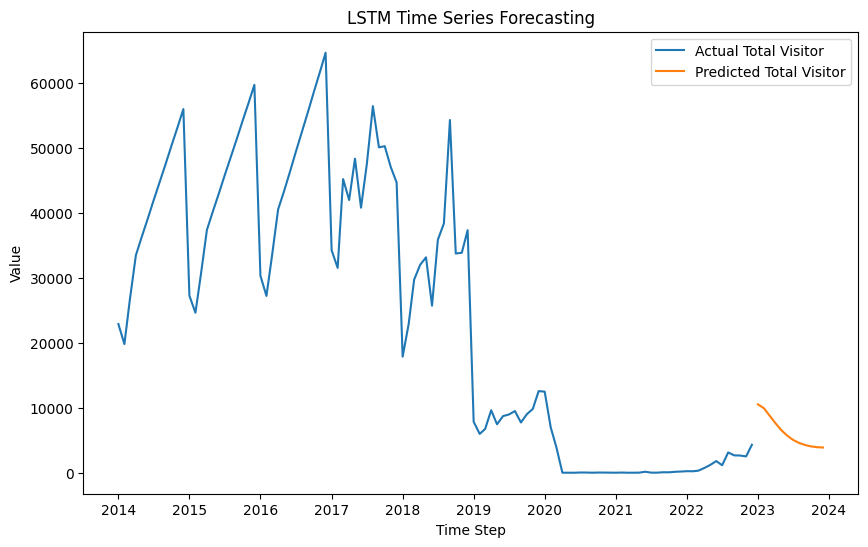

In [ ]:
# Plot the results for both targets (humidity and temperature)
plt.figure(figsize=(10, 6))

plt.plot(df['total_visitor'], label='Actual Total Visitor')
plt.plot(df_test2['total_visitor'], label='Predicted Total Visitor')

plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

# GRU (60:40) Training

In [ ]:
# The Data Shape
df.shape

(108, 2)

In [ ]:
# Splitting the data
test_split=round(len(df)*0.4)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(65, 2)
(43, 2)


In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_scaled = scaler.transform(df)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.28820782, 0.        ],
       [0.2355879 , 0.01037851],
       [0.3523165 , 0.02411477],
       [0.46884056, 0.0497558 ],
       [0.51675587, 0.06807082],
       [0.56467119, 0.07539683],
       [0.61258651, 0.0989011 ],
       [0.66050182, 0.10805861],
       [0.70841714, 0.11477411],
       [0.75633246, 0.14377289],
       [0.80424778, 0.1523199 ],
       [0.85216309, 0.16544567],
       [0.36276549, 0.19200244],
       [0.31788429, 0.21550672],
       [0.41795929, 0.23412698],
       [0.53507994, 0.245116  ],
       [0.58265435, 0.25671551],
       [0.63022875, 0.26800977],
       [0.67780316, 0.28144078],
       [0.72537756, 0.28663004],
       [0.77295197, 0.29426129],
       [0.82056046, 0.30799756],
       [0.86810077, 0.31990232],
       [0.91567518, 0.32814408],
       [0.41511267, 0.33150183],
       [0.3619132 , 0.34920635],
       [0.46884056, 0.37545788],
       [0.58906351, 0.37942613],
       [0.63595609, 0.40964591],
       [0.68796236, 0.43956044],
       [0.

In [ ]:
# Creating the X & Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,12)
testX,testY=createXY(df_for_testing_scaled,12)


In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (53, 12, 2)
trainY Shape--  (53,)


In [ ]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.28820782 0.        ]
 [0.2355879  0.01037851]
 [0.3523165  0.02411477]
 [0.46884056 0.0497558 ]
 [0.51675587 0.06807082]
 [0.56467119 0.07539683]
 [0.61258651 0.0989011 ]
 [0.66050182 0.10805861]
 [0.70841714 0.11477411]
 [0.75633246 0.14377289]
 [0.80424778 0.1523199 ]
 [0.85216309 0.16544567]]
trainY[0]--  0.3627654859714315


In [ ]:
# to reset model
model = 0
model

0

In [ ]:
# Create the GRU model
model = Sequential()

# Add GRU layers
model.add(GRU(activation='relu', units=108, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=52, activation='relu', return_sequences=True))
model.add(GRU(units=4, activation='relu'))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Summary of the Model
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_169 (GRU)               (None, 12, 108)           36288     
                                                                 
 dropout_46 (Dropout)        (None, 12, 108)           0         
                                                                 
 gru_170 (GRU)               (None, 12, 52)            25272     
                                                                 
 gru_171 (GRU)               (None, 4)                 696       
                                                                 
 dense_79 (Dense)            (None, 1)                 5         
                                                                 
Total params: 62261 (243.21 KB)
Trainable params: 62261 (243.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# To reset history
history = 0

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    trainX, trainY,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/100
2/2 [==============================] - 9s 611ms/step - loss: 0.3073 - val_loss: 0.0843
Epoch 2/100
2/2 [==============================] - 0s 56ms/step - loss: 0.2119 - val_loss: 0.0845
Epoch 3/100
2/2 [==============================] - 0s 60ms/step - loss: 0.1245 - val_loss: 0.1135
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0783 - val_loss: 0.1760
Epoch 5/100
2/2 [==============================] - 0s 67ms/step - loss: 0.0531 - val_loss: 0.2702
Epoch 6/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0532 - val_loss: 0.3442
Epoch 7/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0787 - val_loss: 0.3452
Epoch 8/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0754 - val_loss: 0.2984
Epoch 9/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0613 - val_loss: 0.2478
Epoch 10/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0574 - val_loss: 0.2052
Epoch 11/100
2/2 [

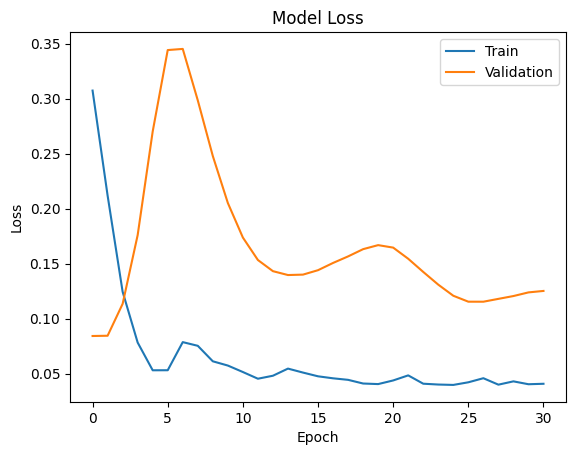

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1/1 [==============================] - 0s 481ms/step
prediction
 [[0.23910698]
 [0.23974669]
 [0.2408947 ]
 [0.24245144]
 [0.24428363]
 [0.2462139 ]
 [0.24843122]
 [0.25090677]
 [0.25369677]
 [0.25677866]
 [0.259967  ]
 [0.26313236]
 [0.26612446]
 [0.2691191 ]
 [0.27201816]
 [0.27488744]
 [0.27771586]
 [0.28038812]
 [0.28290918]
 [0.2855636 ]
 [0.28845826]
 [0.29147357]
 [0.29440042]
 [0.29714194]
 [0.29992232]
 [0.30291852]
 [0.30616158]
 [0.3097651 ]
 [0.31342503]
 [0.31684938]
 [0.3200784 ]]

Prediction Shape- (31, 1)


In [ ]:
# copies the prediction into 2 dimensional array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# inverse the scaling of the prediction data
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(31, 2)

In [ ]:
# inverse the scaling for of the original data
original_copies_array = np.repeat(testY,2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [20000.45  20037.979 20105.328 20196.656 20304.145 20417.385 20547.467
 20692.695 20856.373 21037.176 21224.223 21409.922 21585.457 21761.14
 21931.217 22099.547 22265.479 22422.248 22570.15  22725.873 22895.691
 23072.588 23244.295 23405.129 23568.242 23744.018 23934.275 24145.678
 24360.393 24561.285 24750.719]

Original Values--  [0.000e+00 3.500e+01 3.100e+01 0.000e+00 2.800e+01 2.600e+01 1.300e+01
 4.000e+00 2.600e+01 0.000e+00 3.000e+00 1.300e+01 1.520e+02 1.200e+01
 1.200e+01 7.300e+01 6.400e+01 1.420e+02 1.840e+02 2.340e+02 2.260e+02
 3.170e+02 7.370e+02 1.203e+03 1.792e+03 1.149e+03 3.120e+03 2.672e+03
 2.646e+03 2.511e+03 4.300e+03]


In [ ]:
# Offset the 0 in original to make it suitable for mape
original = np.where(original == 0, 1, original)

In [ ]:
original

array([1.000e+00, 3.500e+01, 3.100e+01, 1.000e+00, 2.800e+01, 2.600e+01,
       1.300e+01, 4.000e+00, 2.600e+01, 1.000e+00, 3.000e+00, 1.300e+01,
       1.520e+02, 1.200e+01, 1.200e+01, 7.300e+01, 6.400e+01, 1.420e+02,
       1.840e+02, 2.340e+02, 2.260e+02, 3.170e+02, 7.370e+02, 1.203e+03,
       1.792e+03, 1.149e+03, 3.120e+03, 2.672e+03, 2.646e+03, 2.511e+03,
       4.300e+03])

In [ ]:
# Calculate RMSE, MAPE, MSE
rmse_gru3 = np.sqrt(mean_squared_error(original, pred))
mae_gru3 = mean_absolute_error(original, pred)
mape_gru3 = np.mean(np.abs((original - pred) / original) * 100)
mape_function_gru3 = mean_absolute_percentage_error(original, pred)
mse_gru3 = mean_squared_error(original, pred)

print(f"Mean Average Error (MAE): {mae_gru3}")
print(f"Root Mean Squared Error (RMSE): {rmse_gru3}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gru3}")
print(f"Mean Absolute Percentage Error Function (MAPE): {mape_function_gru3}")
print(f"Mean Squared Error (MSE): {mse_gru3}")

Mean Average Error (MAE): 21424.039377520163
Root Mean Squared Error (RMSE): 21442.216462331686
Mean Absolute Percentage Error (MAPE): 275238.9460878473
Mean Absolute Percentage Error Function (MAPE): 2752.389460878472
Mean Squared Error (MSE): 459768646.817488


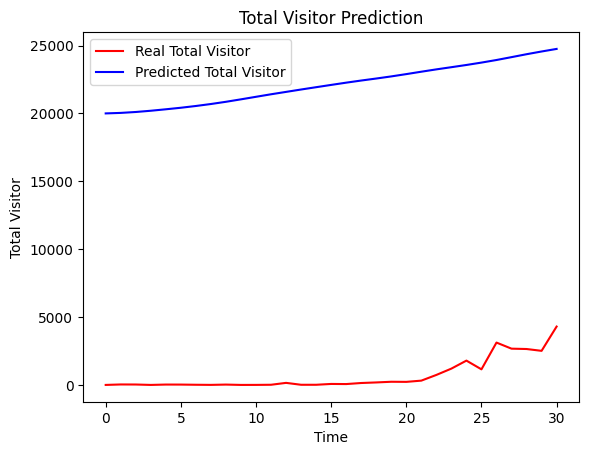

In [ ]:
# plot the prediction
plt.plot(original, color = 'red', label = 'Real Total Visitor')
plt.plot(pred, color = 'blue', label = 'Predicted Total Visitor')
plt.title('Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

In [ ]:
# # Creating the X & Y
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)
# trainX,trainY=createXY(df_for_training_scaled,12)
# testX,testY=createXY(df_for_testing_scaled,12)


# Creating the full data
def createFull(dataset,n_past):
    dataX = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
    return np.array(dataX)
allData=createFull(df_scaled,12)

In [ ]:
# Predict using all the data
prediction=model.predict(allData)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

3/3 [==============================] - 0s 9ms/step
prediction
 [[0.13645008]
 [0.14141443]
 [0.14294465]
 [0.14286786]
 [0.14322893]
 [0.144924  ]
 [0.14803459]
 [0.15238257]
 [0.15759075]
 [0.16334525]
 [0.16946414]
 [0.17594793]
 [0.18261585]
 [0.18628639]
 [0.18579264]
 [0.18379375]
 [0.18250255]
 [0.18327686]
 [0.18651432]
 [0.1919944 ]
 [0.19890015]
 [0.2068729 ]
 [0.2154842 ]
 [0.22427562]
 [0.23300704]
 [0.23790985]
 [0.23817089]
 [0.23773648]
 [0.23762076]
 [0.23927966]
 [0.24119201]
 [0.24421006]
 [0.24934131]
 [0.2553921 ]
 [0.2616085 ]
 [0.2667451 ]
 [0.27026257]
 [0.26729965]
 [0.2604027 ]
 [0.25349027]
 [0.24896342]
 [0.24679461]
 [0.24523349]
 [0.24552205]
 [0.24815796]
 [0.25584376]
 [0.26293457]
 [0.26797485]
 [0.27167764]
 [0.2680228 ]
 [0.25847888]
 [0.24729088]
 [0.23761109]
 [0.23000588]
 [0.22498272]
 [0.2219434 ]
 [0.22077869]
 [0.22015086]
 [0.2213695 ]
 [0.22349752]
 [0.22685403]
 [0.23163822]
 [0.23532972]
 [0.2375441 ]
 [0.2385711 ]
 [0.23910698]
 [0.23974669]

In [ ]:
# Reshape the prediction array
prediction_copies_array = np.repeat(prediction,2, axis=-1)

In [ ]:
# Inverse the prediction array
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),2)))[:,0]

In [ ]:
prediction_copies_array.shape

(96, 2)

In [ ]:
# Inverse the original data
original_copies_array = np.repeat(df_scaled[:,1],2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(df_scaled),2)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [13977.98  14269.22  14358.991 14354.486 14375.669 14475.111 14657.598
 14912.676 15218.218 15555.812 15914.782 16295.161 16686.34  16901.676
 16872.71  16755.443 16679.695 16725.12  16915.049 17236.543 17641.676
 18109.406 18614.596 19130.354 19642.59  19930.219 19945.533 19920.049
 19913.26  20010.58  20122.77  20299.826 20600.857 20955.832 21320.523
 21621.867 21828.223 21654.4   21249.785 20844.26  20578.688 20451.451
 20359.867 20376.797 20531.436 20982.33  21398.318 21694.012 21911.24
 21696.824 21136.922 20480.566 19912.691 19466.525 19171.836 18993.531
 18925.203 18888.37  18959.863 19084.705 19281.617 19562.287 19778.852
 19908.762 19969.012 20000.45  20037.979 20105.328 20196.656 20304.145
 20417.385 20547.467 20692.695 20856.373 21037.176 21224.223 21409.922
 21585.457 21761.14  21931.217 22099.547 22265.479 22422.248 22570.15
 22725.873 22895.691 23072.588 23244.295 23405.129 23568.242 23744.018
 23934.275 24145.678 24360.393 24561.285 24750.719]

Original Va

In [ ]:
# Prediction for all the data
num_predictions = len(pred)

# Create a date range starting from January 1st, 2014
date_index = pd.date_range(start='2014-01-01	', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(pred, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test

,total_visitor
2014-01-01,13977.980469
2014-02-01,14269.219727
2014-03-01,14358.991211
2014-04-01,14354.486328
2014-05-01,14375.668945
...,...
2021-08-01,23934.275391
2021-09-01,24145.677734
2021-10-01,24360.392578
2021-11-01,24561.285156


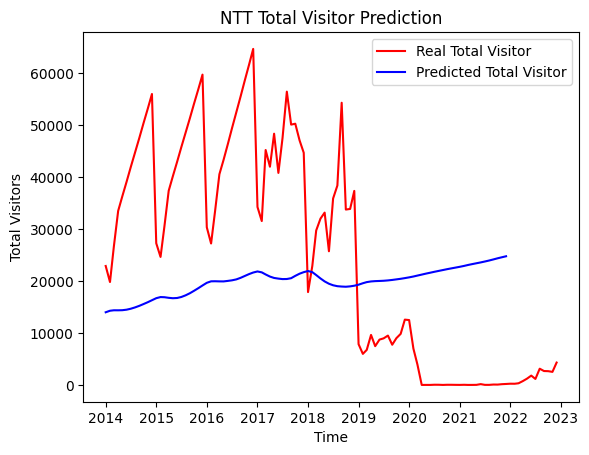

In [ ]:
plt.plot(df['total_visitor'], color = 'red', label = 'Real Total Visitor')
plt.plot(df_test, color = 'blue', label = 'Predicted Total Visitor')
plt.title('NTT Total Visitor Prediction')
plt.xlabel('Time')
plt.ylabel('Total Visitors')
plt.legend()
plt.show()

# GRU (60:40) Prediction

In [ ]:
df_12_months_past=df.iloc[-12:,:]
df_12_months_past.tail()

,total_visitor,total_accomodation
datetime,,
2022-08-01,3120.0,14541
2022-09-01,2672.0,14575
2022-10-01,2646.0,14586
2022-11-01,2511.0,14659
2022-12-01,4300.0,14782


In [ ]:
df_12_months_future = pd.read_csv(uploaded, index_col=[0], parse_dates=['datetime'])
df_12_months_future = df_12_months_future[:12]
df_12_months_future = df_12_months_future.drop('total_visitor', axis=1)
df_12_months_future

,total_accomodation
datetime,
2014-01-01,9024
2014-02-01,9058
2014-03-01,9103
2014-04-01,9187
2014-05-01,9247
2014-06-01,9271
2014-07-01,9348
2014-08-01,9378
2014-09-01,9400


In [ ]:
df_12_months_future["total_visitor"]=0
df_12_months_future=df_12_months_future[["total_visitor","total_accomodation"]]
old_scaled_array=scaler.transform(df_12_months_past)
new_scaled_array=scaler.transform(df_12_months_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [ ]:
full_df.shape

(24, 2)

In [ ]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=12
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 23ms/step


In [ ]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,2, axis=-1)
y_pred_future_12_months = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),2)))[:,0]
print(y_pred_future_12_months)

[24957.744 24064.678 22232.12  19973.596 17735.977 15775.94  14173.876
 12948.352 12038.351 11369.54  10902.595 10579.708]


In [ ]:
len(y_pred_future_12_months)

12

In [ ]:
# Assuming your predictions are for 12 months
num_predictions = len(y_pred_future_12_months)

# Create a date range starting from January 1st, 2023
date_index = pd.date_range(start='2023-01-01', periods=num_predictions, freq='MS')

# Create a DataFrame from the predictions array
df_test3 = pd.DataFrame(y_pred_future_12_months, columns=['total_visitor'], index=date_index)

# Display the DataFrame
df_test3

,total_visitor
2023-01-01,24957.744141
2023-02-01,24064.677734
2023-03-01,22232.119141
2023-04-01,19973.595703
2023-05-01,17735.976562
2023-06-01,15775.940430
2023-07-01,14173.875977
2023-08-01,12948.351562
2023-09-01,12038.350586
2023-10-01,11369.540039


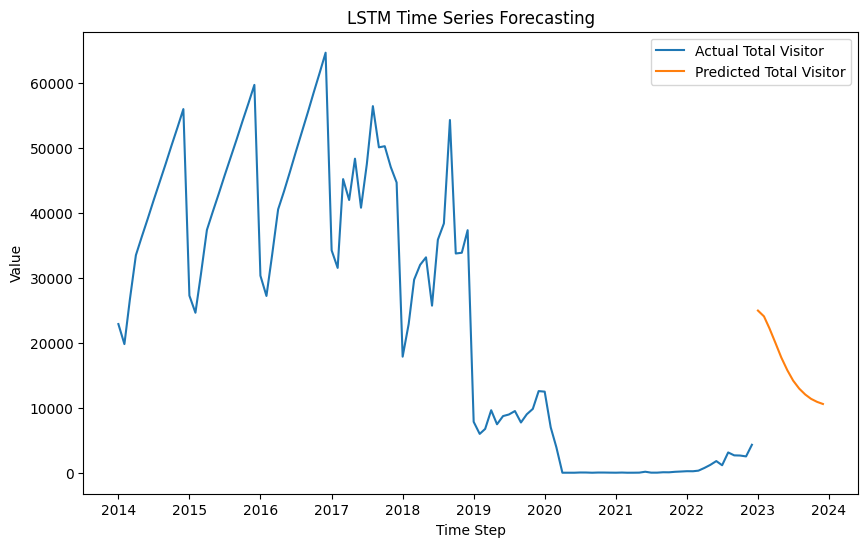

In [ ]:
# Plot the results for both targets (humidity and temperature)
plt.figure(figsize=(10, 6))

plt.plot(df['total_visitor'], label='Actual Total Visitor')
plt.plot(df_test3['total_visitor'], label='Predicted Total Visitor')

plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()

# GRU Model Accuracy Comparation


In [ ]:
# Preparing all the accuracy data
data = {
    'Model': ['80:20 LSTM', '70:30 LSTM', '60:40 LSTM'],
    'RMSE': [rmse_gru1, rmse_gru2, rmse_gru3],
    'MAE': [mae_gru1, mae_gru2, mae_gru3],
    'MAPE': [mape_gru1, mape_gru2, mape_gru3],
    'MAPE (Function)': [mape_function_gru1, mape_function_gru2, mape_function_gru3],
    'MSE': [mse_gru1, mse_gru2, mse_gru3]
}

# Round up all numerical columns
for col in ['RMSE', 'MAE', 'MAPE', 'MSE']:
    data[col] = [round(val, 3) for val in data[col]]

# Round up and append '%' to MAPE (Function) column
data['MAPE (Function)'] = [str(round(val, 3)) + '%' for val in data['MAPE (Function)']]

# Create the DataFrame
df_acc = pd.DataFrame(data)
df_acc

,Model,RMSE,MAE,MAPE,MAPE (Function),MSE
0,80:20 LSTM,2856.934,2549.095,134.598,1.346%,8.162072e+06
1,70:30 LSTM,8693.586,8644.518,14187.837,141.878%,7.557843e+07
2,60:40 LSTM,21442.216,21424.039,275238.946,2752.389%,4.597686e+08


# All Prediction in one plot

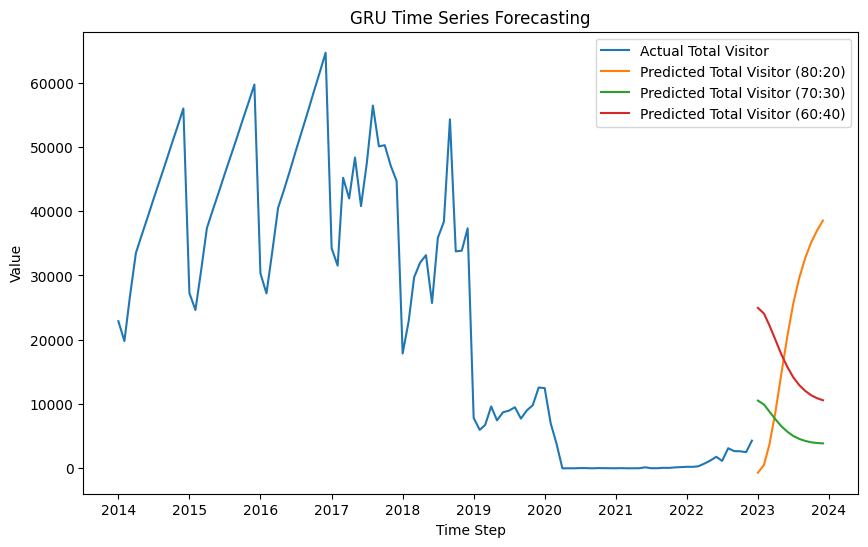

In [ ]:
# Plot the results for both targets (humidity and temperature)
plt.figure(figsize=(10, 6))

plt.plot(df['total_visitor'], label='Actual Total Visitor')
plt.plot(df_test1['total_visitor'], label='Predicted Total Visitor (80:20)')
plt.plot(df_test2['total_visitor'], label='Predicted Total Visitor (70:30)')
plt.plot(df_test3['total_visitor'], label='Predicted Total Visitor (60:40)')

plt.title('GRU Time Series Forecasting')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()